## OKX BOT POSITION ANALYSIS

Comparison between signal given theoretical position of the strategy (current_state.log) and actual executed position in production, built from OKX API polling data periodically (current_state.pos)

In [1]:
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from main import *


In [2]:
def load_positions_3(positions_path: str) -> pd.DataFrame:
    """
    Load positions_3.csv and convert quantities to directions.
    
    Args:
        positions_path (str): Path to positions_3.csv.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and directions (1, -1, 0) for each symbol.
    """
    df = pd.read_csv(positions_path, index_col=0, parse_dates=True)
    df.index = df.index.tz_localize(None)  # Remove timezone for consistency
    # Convert quantities to directions: >0 -> 1, <0 -> -1, 0 -> 0
    df = df.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    return df

In [5]:
def parse_current_state_log(log_path: str) -> pd.DataFrame:
    """
    Parse current_state.log into a DataFrame with timestamps as index and tickers as columns.
    The log file is expected to have lines with the following format:
    
        2025/02/28 00:16:52.837068 'AXS-USDT-SWAP'; 1, 'DOGE-USDT-SWAP'; -1, 'LINK-USDT-SWAP'; 1
    
    For each line:
      - The first 26 characters are the timestamp.
      - The regex extracts the symbol and the integer value (with an optional sign).
      - If a ticker is not present in a new line, it is assumed that the position is closed (0).
      - If multiple lines share the same timestamp, the last one is kept.
    
    Args:
        log_path (str): Path to current_state.log.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and columns for each ticker.
    """
    # New regex: Accept a colon or semicolon as delimiter
    pattern = re.compile(r"'([^']+)'\s*:\s*([-+]?\s*\d+)(?:,|$)")
    entries = []
    
    with open(log_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Extract the timestamp (first 26 characters)
            dt_str = line[:26]
            rest = line[26:].strip()
            try:
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
            except Exception:
                continue
            matches = pattern.findall(rest)
            positions_dict = {}
            for sym, val_str in matches:
                if not re.match(r'^[A-Z0-9]+-USDT-SWAP$', sym):
                    continue
                ticker = sym.split('-')[0]
                try:
                    value_int = int(val_str.replace(" ", ""))
                except Exception:
                    continue
                positions_dict[ticker] = value_int
            entries.append({"timestamp": dt, "positions": positions_dict})
    
    if not entries:
        return pd.DataFrame()
    
    # Merge entries with duplicate timestamps (last one wins)
    timestamp_dict = {}
    for entry in entries:
        ts = entry["timestamp"]
        if ts in timestamp_dict:
            timestamp_dict[ts].update(entry["positions"])
        else:
            timestamp_dict[ts] = entry["positions"]
    
    # Sort timestamps and collect all unique tickers
    timestamps = sorted(timestamp_dict.keys())
    all_tickers = set()
    for positions in timestamp_dict.values():
        all_tickers.update(positions.keys())
    all_tickers = sorted(all_tickers)
    
    # Build the DataFrame incrementally
    df_data = []
    current_positions = {ticker: 0 for ticker in all_tickers}
    
    for ts in timestamps:
        positions = timestamp_dict[ts]
        # Update current positions for tickers present in this snapshot
        for ticker, value in positions.items():
            current_positions[ticker] = value
        # For tickers not mentioned in this snapshot, set them to 0 (position closed)
        for ticker in all_tickers:
            if ticker not in positions:
                current_positions[ticker] = 0
        row = {"timestamp": ts}
        row.update(current_positions.copy())
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    if df.empty:
        return pd.DataFrame()
    
    df.set_index("timestamp", inplace=True)
    df.sort_index(inplace=True)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    return df

In [11]:
def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Parse current_state.pos into a DataFrame with timestamps as index and tickers as columns.
    First builds a DataFrame with raw position quantities, then processes it to apply a dust threshold
    based on dollar value (< $140 absolute value), and finally converts to +1, -1, 0 positions.
    
    Args:
        log_path (str): Path to current_state.pos.
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and position directions for each ticker.
    """
    pattern = re.compile(r"'([^']+)':([-]?\d+\.\d+|\d+)")
    valid_symbols = set()
    invalid_symbols = set()
    data = []
    all_tickers = set()
    
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                dt_str = line[:24]
                rest = line[24:].strip()
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                positions_dict = {}
                for sym, pos in pairs:
                    if sym == 'equity':
                        continue
                    if sym in invalid_symbols:
                        continue
                    if sym.isdigit():
                        print(f"ERROR: Invalid numerical symbol '{sym}' at {dt_str}, skipping")
                        invalid_symbols.add(sym)
                        continue
                    if not re.match(r'^[A-Z0-9]+-[A-Z]+-(SWAP|PERP)$', sym):
                        print(f"WARNING: Symbol '{sym}' at {dt_str} does not match expected format, skipping")
                        invalid_symbols.add(sym)
                        continue
                    if sym not in valid_symbols:
                        valid_symbols.add(sym)
                    ticker = sym.split('-')[0]
                    all_tickers.add(ticker)
                    # Store the raw position quantity (float)
                    positions_dict[ticker] = float(pos)
                data.append({"timestamp": dt, "positions": positions_dict})
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e
    
    if not data:
        return pd.DataFrame()
    
    # Build a timestamp dictionary with raw quantities
    timestamp_dict = {}
    for entry in data:
        ts = entry["timestamp"]
        if ts not in timestamp_dict:
            timestamp_dict[ts] = {}
        timestamp_dict[ts].update(entry["positions"])
    
    timestamps = sorted(timestamp_dict.keys())
    positions_list = [timestamp_dict[ts] for ts in timestamps]
    
    # Create a DataFrame with raw quantities
    df_data = []
    for ts, positions in zip(timestamps, positions_list):
        row = {"timestamp": ts}
        for ticker in all_tickers:
            row[ticker] = 0.0  # Default to 0.0 (float)
        for ticker, qty in positions.items():
            row[ticker] = qty
        df_data.append(row)
    
    qty_df = pd.DataFrame(df_data)
    qty_df.set_index("timestamp", inplace=True)
    qty_df.sort_index(inplace=True)
    
    return qty_df


def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = False) -> float:
    """Helper function to get the next available price."""
    col = f"{symbol}-USDT-SWAP_{column}"
    if col not in df_prices.columns:
        return float("nan")
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return float("nan")

def calculate_position_values(qty_df: pd.DataFrame, price_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the dollar value of positions by multiplying quantities with next bar prices.
    
    Args:
        qty_df (pd.DataFrame): DataFrame with timestamps as index and raw position quantities.
        price_data (pd.DataFrame): DataFrame with prices (index: timestamps, columns: tickers).
    
    Returns:
        pd.DataFrame: DataFrame with timestamps as index and dollar values for each ticker.
    """
    values_df = qty_df.copy()
    
    for ts in values_df.index:
        for ticker in values_df.columns:
            qty = values_df.at[ts, ticker]
            if qty == 0:
                values_df.at[ts, ticker] = 0.0
                continue
            
            price = get_next_bar_price(ticker, ts, price_data)
            
            values_df.at[ts, ticker] = qty * price if not pd.isna(price) else float("nan")
    
    return values_df

def apply_dust_threshold(values_df: pd.DataFrame, threshold: float = 140.0) -> pd.DataFrame:
    """
    Apply a dust threshold to the position values DataFrame. Filter out positions with
    absolute dollar value less than threshold, then convert to +1, -1, 0 directions.
    
    Args:
        values_df (pd.DataFrame): DataFrame with timestamps as index and dollar values.
        threshold (float): Dollar value threshold below which a position is considered dust.
    
    Returns:
        pd.DataFrame: DataFrame with +1, -1, 0 positions after applying the threshold.
    """
    # Copy the values DataFrame
    adjusted_df = values_df.copy()
    
    # Filter out values where absolute value is less than threshold (set to 0)
    adjusted_df = adjusted_df.mask(adjusted_df.abs() < threshold, 0.0)
    
    # Convert to directional DataFrame (+1, -1, 0)
    directional_df = adjusted_df.copy()
    directional_df = directional_df.apply(lambda x: x.map(lambda y: 1 if y > 0 else -1 if y < 0 else 0))

    
    return directional_df


In [12]:
def plot_ticker(positions_3_df, log_df, pos_df, ticker, dfs_to_plot=[1, 2, 3]):
    """
    Plot the values of a chosen ticker for the specified DataFrames.
    
    Args:
        positions_3_df (pd.DataFrame): DataFrame from positions_3.csv.
        log_df (pd.DataFrame): DataFrame from current_state.log.
        pos_df (pd.DataFrame): DataFrame from current_state.pos.
        ticker (str): The ticker to plot (e.g., 'TON', 'ZRX').
        dfs_to_plot (list): List of DataFrame numbers to plot (1: positions_3_df, 2: log_df, 3: pos_df).
                           Default is [1, 2, 3] (all DataFrames).
    """
    plt.figure(figsize=(12, 6))
    
    # Debug information
    print(f"Plotting ticker: {ticker}")
    if ticker in positions_3_df.columns and 1 in dfs_to_plot:
        print(f"positions_3_df[{ticker}] shape: {positions_3_df[ticker].shape}, type: {type(positions_3_df[ticker])}, index type: {type(positions_3_df.index)}")
        print(f"positions_3_df[{ticker}] values: {positions_3_df[ticker].head()}")
    if ticker in log_df.columns and 2 in dfs_to_plot:
        print(f"log_df[{ticker}] shape: {log_df[ticker].shape}, type: {type(log_df[ticker])}")
    if ticker in pos_df.columns and 3 in dfs_to_plot:
        print(f"pos_df[{ticker}] shape: {pos_df[ticker].shape}, type: {type(pos_df[ticker])}")
    
    # Plot positions_3_df if selected
    if 1 in dfs_to_plot and ticker in positions_3_df.columns:
        x = positions_3_df.index.to_numpy()
        y = positions_3_df[ticker].to_numpy()
        mask = ~np.isnan(y)  # Remove NaN values
        plt.plot(x[mask], y[mask], label='positions_3.csv', marker='o', linestyle='-', color='blue')
    
    # Plot log_df if selected
    if 2 in dfs_to_plot and ticker in log_df.columns:
        x = log_df.index.to_numpy()
        y = log_df[ticker].to_numpy()
        mask = ~np.isnan(y)
        plt.plot(x[mask], y[mask], label='current_state.log', marker='s', linestyle='--', color='orange')
    
    # Plot pos_df if selected
    if 3 in dfs_to_plot and ticker in pos_df.columns:
        x = pos_df.index.to_numpy()
        y = pos_df[ticker].to_numpy()
        mask = ~np.isnan(y)
        plt.plot(x[mask], y[mask], label='current_state.pos', marker='^', linestyle='-.', color='green')
    
    plt.title(f'Position Values for Ticker: {ticker}')
    plt.xlabel('Timestamp')
    plt.ylabel('Position Value (+1, -1, 0)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Ensure the x-axis uses datetime formatting
    plt.gcf().autofmt_xdate()
    
    plt.show()

## Compare positions from different file sources

In [ ]:
positions_3_path = "okx_bot_data/positions_3.csv"
log_path = "okx_bot_data/current_state.log"
pos_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

df_prices = load_price_data(price_path)

positions_3_df = load_positions_3(positions_3_path)

print("\nParsing current_state.log...")
theo_df = parse_current_state_log(log_path)
print("\ncurrent_state.log DataFrame:")
print(theo_df)
theo_df.to_csv("theo_position.csv")

print("\nParsing current_state.pos...")
qty_df = parse_executed_positions_log(pos_path)
print("\ncurrent_state.pos position quantity DataFrame:")
print(qty_df)
qty_df.to_csv("position_quantity.csv")


C:\Users\Z640\AppData\Local\Temp\ipykernel_13876\4281757878.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)



Parsing current_state.log...

current_state.log DataFrame:
                            1INCH  AAVE  ADA  APT  ARB  ATH  ATOM  AVAX  AXS  \
timestamp                                                                      
2025-02-28 00:16:52.837068      1     1    1   -1    1   -1     1     0    1   
2025-02-28 03:20:54.817918      1     1    1   -1    1   -1     1     0    1   
2025-02-28 03:32:49.488144      1     1    1   -1    1   -1     1     0    1   
2025-02-28 04:14:53.948554      1     1    1   -1    1   -1     1     0    1   
2025-02-28 04:52:50.455376      1     1    1   -1    1   -1     1     0    1   
...                           ...   ...  ...  ...  ...  ...   ...   ...  ...   
2025-03-11 10:12:35.773991      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:22:34.885999      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:32:43.423917      1     0    0   -1    0   -1     0     0    1   
2025-03-11 10:42:40.760760      1     0    0   -1    0   -1 

## Filter for desired time window

In [ ]:
# Define the time range for filtering
start_time = datetime.strptime("2025/03/01 12:20:38.977684", "%Y/%m/%d %H:%M:%S.%f")
end_time = datetime.strptime("2025/03/10 23:52:38.458488", "%Y/%m/%d %H:%M:%S.%f")

print("\nFiltering DataFrames to time range: 2025/03/01 12:20:38.977684 to 2025/03/10 23:52:38.458488")
positions_3_df = positions_3_df.loc[start_time:end_time]
theo_df = theo_df.loc[start_time:end_time]
qty_df = qty_df.loc[start_time:end_time]

print("\Calculating position values from current_state.pos...")
values_df = calculate_position_values(qty_df, df_prices)
print("\ncurrent_state.pos position values DataFrame:")
print(values_df)
values_df.to_csv("position_values.csv")

print("\Removing dust to current_state.pos...")
# select desired threshold to filter out "dust position" in dollars
threshold = 140
pos_dir_df = apply_dust_threshold(values_df,threshold=threshold)
print("\ncurrent_state.pos position direction DataFrame with dust removed:")
print(pos_dir_df)
pos_dir_df.to_csv("position_direction.csv")


Filtering DataFrames to time range: 2025/03/01 12:20:38.977684 to 2025/03/10 23:52:38.458488
\Calculating position values from current_state.pos...

current_state.pos position values DataFrame:
                                  ARB       GAS      ATOM       GRT  \
timestamp                                                             
2025-03-01 12:24:33.472600     2.0375  1357.920 -1299.897  1323.378   
2025-03-01 12:26:34.812200     2.0375  1357.920 -1299.897  1323.378   
2025-03-01 13:50:38.730200     2.0170  1354.230 -1287.675  1310.904   
2025-03-01 18:20:35.718400     2.0575  1371.040 -1304.262  1317.708   
2025-03-01 18:52:41.515300     2.0660  1375.550 -1308.627  1325.646   
...                               ...       ...       ...       ...   
2025-03-10 12:12:29.216200 -1441.2346 -1400.672     4.021  1441.889   
2025-03-10 12:22:28.337900 -1435.3456 -1398.267     4.008  1431.298   
2025-03-10 12:32:35.319800 -1430.6344 -1392.495     3.996  1422.220   
2025-03-10 12:42:33.3988

## PLOT POSITION HIsTORY FROM DIFFERENT LOG FILES (SIGNAL / EXECUTION / BACKTEST)

Plotting ticker: BCH
log_df[BCH] shape: (436,), type: <class 'pandas.core.series.Series'>
pos_df[BCH] shape: (413,), type: <class 'pandas.core.series.Series'>


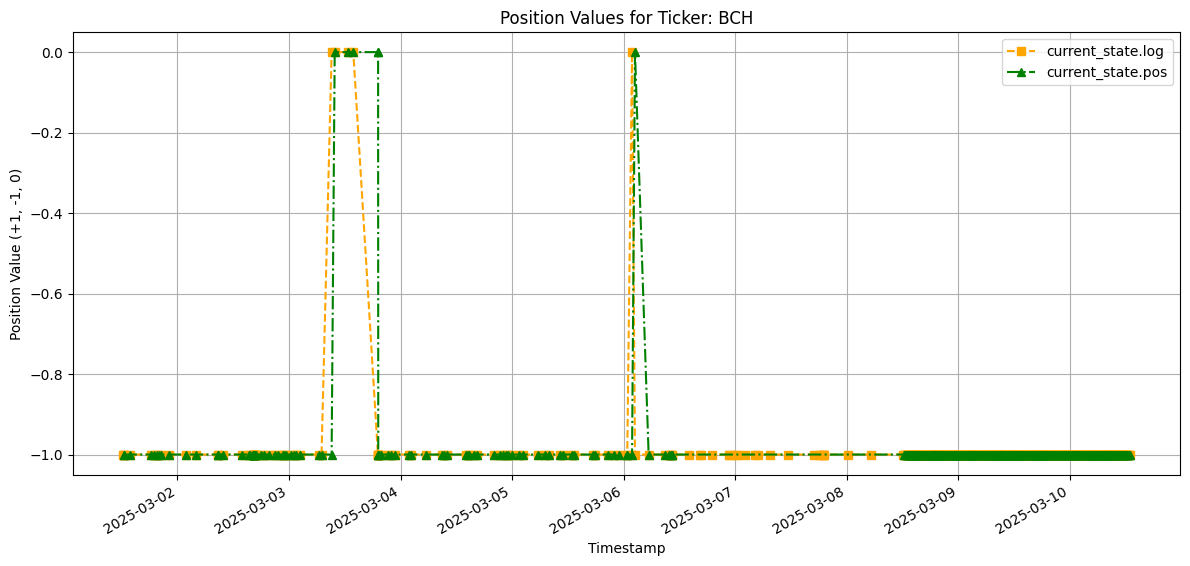

Plotting ticker: BCH
positions_3_df[BCH] shape: (433,), type: <class 'pandas.core.series.Series'>, index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
positions_3_df[BCH] values: 2025-03-01 12:30:00   -1
2025-03-01 13:00:00   -1
2025-03-01 13:30:00   -1
2025-03-01 14:00:00   -1
2025-03-01 14:30:00   -1
Name: BCH, dtype: int64
pos_df[BCH] shape: (413,), type: <class 'pandas.core.series.Series'>


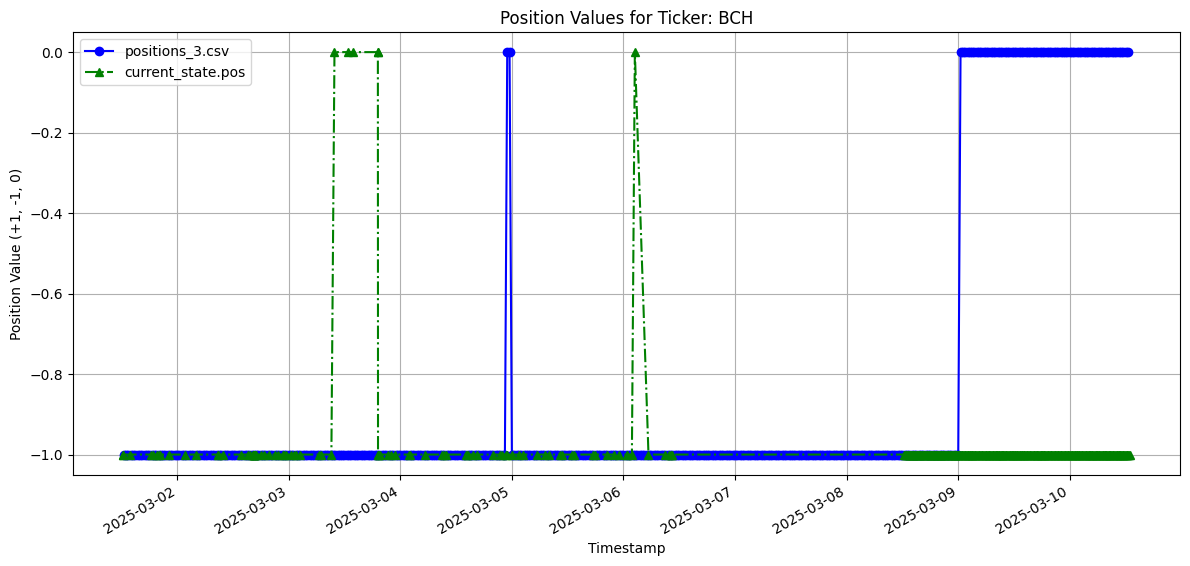

" plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'DOT', [1,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'BTC', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'BTC', [1,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'MANA', [2,3])\nplot_ticker(positions_3_df, log_df, pos_df, 'MANA', [1,3]) "

In [20]:
plot_ticker(positions_3_df, theo_df, pos_dir_df, 'BCH', [2,3])
plot_ticker(positions_3_df, theo_df, pos_dir_df, 'BCH', [1,3])
""" plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'DOT', [1,3])
plot_ticker(positions_3_df, log_df, pos_df, 'BTC', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'BTC', [1,3])
plot_ticker(positions_3_df, log_df, pos_df, 'MANA', [2,3])
plot_ticker(positions_3_df, log_df, pos_df, 'MANA', [1,3]) """